In [2]:
# Reliable XAI (Modular, CSV/ARFF, Multi-Model) — Jupyter single-cell version
import os, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

# ===================== tiny utils =====================
def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s); np.random.seed(s); os.environ["PYTHONHASHSEED"]=str(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad: X.drop(columns=bad, inplace=True)
    if X.isna().any().any(): X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def to_numeric_features_only(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            try: df[c] = pd.to_numeric(df[c], errors="ignore")
            except Exception: pass
    return df.select_dtypes(include=[np.number])

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv)>=2 else sv[0])
    else:
        arr = np.asarray(sv)
    if arr.ndim==2 and arr.shape[1]==n_features:
        return np.abs(arr).mean(axis=0)
    feat_axes = [ax for ax,d in enumerate(arr.shape) if d==n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim-1)))
    return np.abs(arr.reshape(-1, n_features)).mean(axis=0)

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a,b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5*(rho+1)

def _decode_bytes_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object and len(df[c])>0 and isinstance(df[c].iloc[0], (bytes, bytearray)):
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
    return df

def _binarize_target(y: pd.Series) -> pd.Series:
    y = y.copy()
    if pd.api.types.is_numeric_dtype(y):
        uniq = pd.unique(y)
        if len(uniq) > 2: return (y.astype(float) > 0).astype(int)
        vals = set(pd.unique(y))
        if vals.issubset({0,1}): return y.astype(int)
        if vals.issubset({1,2}): return (y.astype(int) == 2).astype(int)
        return (y.astype(float) > 0).astype(int)
    y_ = y.astype(str).str.strip().str.lower()
    truthy = {"true","y","yes","defect","defects","bug","bugs","t","1"}
    falsy  = {"false","n","no","clean","f","0"}
    return y_.apply(lambda v: 1 if (v in truthy) else (0 if v in falsy else (1 if v not in falsy else 0))).astype(int)

# ===================== config =====================
@dataclass
class PipelineConfig:
    target_col: Optional[str] = None
    rng: int = 42
    n_splits: int = 5
    use_smote: bool = True
    smote_k_max: int = 5
    # SHAP
    shap_background_size: int = 1024
    shap_eval_size: int = 10_000
    shap_nsamples: int = 600
    # Concordance
    perm_repeats: int = 40
    concordance_top_k: int = 25
    # RF / ExtraTrees
    rf_n_estimators: int = 1600
    rf_max_depth: Optional[int] = 10
    rf_min_samples_leaf: int = 3
    # LR
    lr_C: float = 1.0
    lr_max_iter: int = 1000

# ---- dataset registry rooted at ./../dataset ----
BASE_DATA_DIR = "./../dataset"
DATASET_REGISTRY: Dict[str, Dict[str, Optional[str]]] = {
    "CM1": {"path": os.path.join(BASE_DATA_DIR, "CM1.csv"), "target": "Defective"},
    "PC1": {"path": os.path.join(BASE_DATA_DIR, "pc1.arff"), "target": None},
    "PC2": {"path": os.path.join(BASE_DATA_DIR, "pc2.arff"), "target": None},
    "PC3": {"path": os.path.join(BASE_DATA_DIR, "pc3.arff"), "target": None},
    "PC4": {"path": os.path.join(BASE_DATA_DIR, "pc4.arff"), "target": None},
    "MC1": {"path": os.path.join(BASE_DATA_DIR, "mc1.arff"), "target": None},
    "MC2": {"path": os.path.join(BASE_DATA_DIR, "mc2.arff"), "target": None},
    "MW1": {"path": os.path.join(BASE_DATA_DIR, "mw1.arff"), "target": None},
}
TARGET_CANDIDATES = ["Defective","defective","defects","bug","bugs","class","label","target","c"]

# ===================== dataset loader =====================
def _resolve_dataset(dataset: str) -> Tuple[str, Optional[str]]:
    if os.path.exists(dataset):  # direct path given
        return dataset, None
    key = dataset.strip().upper()
    if key in DATASET_REGISTRY:
        entry = DATASET_REGISTRY[key]
        return entry["path"], entry.get("target")
    raise FileNotFoundError(f"Dataset '{dataset}' not found as path or alias. "
                            f"Known aliases: {list(DATASET_REGISTRY.keys())}")

def _read_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, header=None)
        hdr = df.iloc[0].astype(str).tolist()
        if len(set(hdr)) == len(hdr):
            df2 = df.iloc[1:].copy(); df2.columns = hdr; return df2
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
        return df

def _read_arff(path: str) -> pd.DataFrame:
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    return _decode_bytes_cols(df)

def _auto_find_target(df: pd.DataFrame, hint: Optional[str]) -> str:
    if hint and hint in df.columns: return hint
    lowmap = {c.lower(): c for c in df.columns}
    for k in TARGET_CANDIDATES:
        if k.lower() in lowmap: return lowmap[k.lower()]
    return df.columns[-1]  # common in ARFFs

def load_dataset(dataset: str, target_col: Optional[str]=None) -> Tuple[pd.DataFrame, pd.Series]:
    path, suggested = _resolve_dataset(dataset)
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv": df = _read_csv(path)
    elif ext == ".arff": df = _read_arff(path)
    else: raise ValueError(f"Unsupported file type: {ext} (expected .csv or .arff)")
    tgt = target_col or _auto_find_target(df, suggested)
    if tgt not in df.columns:
        raise ValueError(f"Target '{tgt}' not found in {os.path.basename(path)}. "
                         f"Available: {list(df.columns)}")
    y = _binarize_target(df[tgt].copy())
    X = to_numeric_features_only(df.drop(columns=[tgt]).copy())
    return X, y

# ===================== model wrappers =====================
class BaseModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg; self._cols: List[str] = []
    def fit(self, X: pd.DataFrame, y: pd.Series): raise NotImplementedError
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray: raise NotImplementedError
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series: raise NotImplementedError
    def permutation_importance_stable(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        cols = self._cols; nrep = self.cfg.perm_repeats
        rng0 = np.random.RandomState(1)
        base_auc = roc_auc_score(y, self.predict_proba(X)[:,1])
        rsum = np.zeros(len(cols))
        for r in range(nrep):
            rng = np.random.RandomState(rng0.randint(1_000_000))
            deltas = []
            for c in cols:
                Xp = X.copy(); Xp[c] = rng.permutation(Xp[c].values)
                auc_p = roc_auc_score(y, self.predict_proba(Xp)[:,1])
                deltas.append(max(base_auc - auc_p, 0.0))
            ranks = pd.Series(deltas, index=cols).rank(pct=True)
            rsum += ranks.values
        return pd.Series(rsum/nrep, index=cols, name="perm_rank")

class TreeModel(BaseModel):
    def __init__(self, estimator, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state); self.model = estimator
    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._cols = list(X.columns); self.model.fit(X[self._cols], y); return self
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(X[self._cols])
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        cols = self._cols; X_bg, X_eval = X_bg[cols], X_eval[cols]
        rng = np.random.RandomState(0)
        bg = X_bg.iloc[rng.choice(len(X_bg), size=min(len(X_bg), self.cfg.shap_background_size), replace=False)]
        sample = X_eval if len(X_eval) <= self.cfg.shap_eval_size \
                 else X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]
        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="interventional")
            sv = expl.shap_values(sample)
        except Exception:
            expl = shap.KernelExplainer(self.model.predict_proba, bg, link="logit")
            sv = expl.shap_values(sample, nsamples=self.cfg.shap_nsamples)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

class LRModel(BaseModel):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state)
        self.model = LogisticRegression(
            C=cfg.lr_C, max_iter=cfg.lr_max_iter, class_weight="balanced",
            solver="lbfgs", n_jobs=None, random_state=random_state
        )
    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._cols = list(X.columns); self.model.fit(X[self._cols], y); return self
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(X[self._cols])
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        cols = self._cols; X_bg, X_eval = X_bg[cols], X_eval[cols]
        rng = np.random.RandomState(0)
        bg = X_bg.iloc[rng.choice(len(X_bg), size=min(len(X_bg), self.cfg.shap_background_size), replace=False)]
        sample = X_eval if len(X_eval) <= self.cfg.shap_eval_size \
                 else X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]
        expl = shap.KernelExplainer(lambda Z: self.model.predict_proba(pd.DataFrame(Z, columns=cols)), bg, link="logit")
        sv = expl.shap_values(sample, nsamples=self.cfg.shap_nsamples)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

def build_model(model_name: str, cfg: PipelineConfig, random_state: int) -> BaseModel:
    name = model_name.strip().lower()
    if name in ("rf","random_forest","random-forest"):
        est = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=True
        ); return TreeModel(est, cfg, random_state)
    if name in ("extra_trees","extratrees","et"):
        est = ExtraTreesClassifier(
            n_estimators=cfg.rf_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=False
        ); return TreeModel(est, cfg, random_state)
    if name in ("logreg","logistic","logistic_regression","lr"):
        return LRModel(cfg, random_state)
    raise ValueError("Unknown model. Use: 'random_forest', 'extra_trees', 'logistic_regression'.")

# ===================== reliability k-fold =====================
def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig, model_name: str):
    set_seed(cfg.rng); X = drop_constant_and_fillna(X)
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)

    tA,tF,tP,tR, A,F,P,R = [],[],[],[], [],[],[], []
    expl_tr, expl_te, rows = [], [], []

    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        seed = cfg.rng + fold; set_seed(seed)
        Xtr,Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr,yte = y.iloc[tr].copy(), y.iloc[te].copy()
        Xfit,yfit = Xtr,ytr
        if cfg.use_smote:
            try:
                minority = int((ytr==1).sum()); k = min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception: pass

        model = build_model(model_name, cfg, random_state=seed).fit(Xfit,yfit)

        p_tr = model.predict_proba(Xtr)[:,1]; yhat_tr = (p_tr>=0.5).astype(int)
        tA.append(roc_auc_score(ytr,p_tr)); tF.append(f1_score(ytr,yhat_tr))
        tP.append(precision_score(ytr,yhat_tr, zero_division=0)); tR.append(recall_score(ytr,yhat_tr))

        p_te = model.predict_proba(Xte)[:,1]; yhat_te = (p_te>=0.5).astype(int)
        A.append(roc_auc_score(yte,p_te)); F.append(f1_score(yte,yhat_te))
        P.append(precision_score(yte,yhat_te, zero_division=0)); R.append(recall_score(yte,yhat_te))

        gtr = model.shap_importance(Xfit, Xtr)
        gte = model.shap_importance(Xfit, Xte)
        expl_tr.append(gtr); expl_te.append(gte)

        perm_rank = model.permutation_importance_stable(Xte, yte)
        gte_r, perm_r = gte.rank(pct=True), perm_rank.rank(pct=True)

        K = min(cfg.concordance_top_k, len(gte_r))
        top = list(set(gte_r.sort_values(ascending=False).head(K).index) &
                   set(perm_r.sort_values(ascending=False).head(K).index))
        concord = spearman_rank_corr(gte_r.loc[top], perm_r.loc[top]) if top else np.nan

        rows.append({
            "fold": fold,
            "Train_AUC": tA[-1], "Train_F1": tF[-1], "Train_Precision": tP[-1], "Train_Recall": tR[-1],
            "AUC": A[-1], "F1": F[-1], "Precision": P[-1], "Recall": R[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": concord
        })

    perfold = pd.DataFrame(rows)

    def _mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        if len(series_list)<2: return np.nan
        vals=[spearman_rank_corr(series_list[i], series_list[j])
              for i in range(len(series_list)) for j in range(i+1,len(series_list))]
        return float(np.nanmean(vals))
    stability = _mean_pairwise_spearman(expl_te)

    gap = float(np.mean(tA)) - float(np.mean(A))
    ri = float(np.nanmean([
        rescale01_rho(perfold["Generalizability"].mean()),
        rescale01_rho(perfold["Concordance"].mean()),
        rescale01_rho(stability)
    ]))

    summary = pd.DataFrame([{
        "Model": model_name,
        "Train_AUC_mean": float(np.mean(tA)), "AUC_mean": float(np.mean(A)),
        "F1_mean": float(np.mean(F)), "Precision_mean": float(np.mean(P)), "Recall_mean": float(np.mean(R)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability), "ReliabilityIndex": ri, "OverfitGap": gap
    }])

    mean_imp = pd.concat(expl_te, axis=1)
    mean_imp.columns = [f"fold{i+1}" for i in range(mean_imp.shape[1])]
    mean_imp = mean_imp.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}

# ===================== plotting =====================
def plot_topk(importance: pd.Series, top_k=10, title=None):
    if importance is None or importance.empty: return
    imp = importance.sort_values(ascending=False).head(min(top_k, len(importance)))
    y = np.arange(len(imp))
    plt.figure(figsize=(9, max(4, 0.5*len(imp))))
    plt.barh(y, imp.values); plt.yticks(y, imp.index)
    plt.gca().invert_yaxis(); plt.xlabel("importance")
    plt.title(title or f"Top {len(imp)} — SHAP importance"); plt.tight_layout(); plt.show()

# ===================== run helper for notebooks =====================
def run_experiment(*, dataset: str, model_name: str = "random_forest",
                   target_col: Optional[str] = None, top_k: int = 10,
                   cfg_overrides: Optional[Dict]=None, show_plot: bool = True):
    cfg = PipelineConfig()
    if cfg_overrides:
        for k,v in cfg_overrides.items():
            if hasattr(cfg,k): setattr(cfg,k,v)
            else: raise KeyError(f"Invalid override: {k}")

    set_seed(cfg.rng)
    X,y = load_dataset(dataset, target_col=target_col)
    df_cls, arts = run_reliability_kfold(X,y,cfg, model_name=model_name)

    try:
        from IPython.display import display; display(df_cls.round(4))
    except Exception:
        print(df_cls.round(4))
    if show_plot:
        plot_topk(arts["mean_importance_test"], top_k=top_k,
                  title=f"Top {top_k} — {model_name.upper()} (SHAP)")
    return df_cls, arts

# ----------------- Examples (uncomment to run) -----------------
# df_cm1, arts_cm1 = run_experiment(dataset="CM1", model_name="random_forest")
# df_pc2, arts_pc2 = run_experiment(dataset="PC2", model_name="extra_trees")
# df_lr, arts_lr   = run_experiment(dataset="PC1", model_name="logistic_regression",
#                                   cfg_overrides=dict(shap_nsamples=400))

/Users/uditjain/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
 99%|===================| 516/522 [00:24<00:00]        Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/261 [00:00<?, ?it/s]

/Users/uditjain/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
 97%|=================== | 508/522 [00:25<00:00]       Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/261 [00:00<?, ?it/s]

Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/66 [00:00<?, ?it/s]

/Users/uditjain/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
 98%|===================| 513/524 [00:25<00:00]        Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/262 [00:00<?, ?it/s]

/Users/uditjain/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
 99%|===================| 517/524 [00:25<00:00]        /Users/uditjain/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
 97%|=================== | 507/524 [00:26<00:00]       Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/262 [00:00<?, ?it/s]

Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/65 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9977,0.7397,0.2284,0.236,0.2694,0.9788,0.4004,0.81,0.8649,0.258


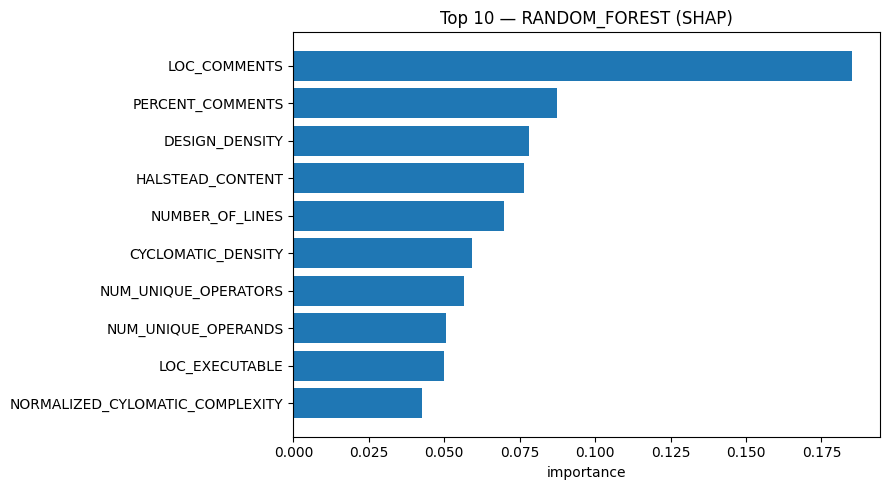

In [2]:
df_cm1, arts_cm1 = run_experiment(dataset="CM1", model_name="random_forest")